In [ ]:
# !pip install category_encoders
# !pip3 install eli5
# !pip3 install pdpbox
# !pip install folium

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium as g

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.pipeline import make_pipeline

from category_encoders import OrdinalEncoder

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance

In [5]:
df = pd.read_csv('./Employee.csv')

In [6]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [7]:
len(df[df.duplicated()])

1889

In [8]:
# 중복행이 1889개 확인 되었고 이를 드랍하였습니다.

In [9]:
df.isna().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [10]:
# 결측값은 없습니다.

In [11]:
ddf = df.drop_duplicates()
ddf = ddf.reset_index(drop=True)

In [12]:
# 살펴본 결과, 이상치로 판단되는 값은 없었습니다.
# 다만, 편의를 위해 Age는 그룹화하고, 경력에서 6년과 7년 데이터는 수가 부족하여 드랍하기로 결정했습니다.
# 추가로 Education의 값들은 순서가 있다고 보고, Bachelors = 1, Masters = 2, PHD = 3으로 변경하기로 결정했습니다.

In [100]:
g_map = g.Map(location=[12.966916616203198, 77.59780194862401])

In [ ]:
bangalore = g.Marker([12.966916616203198, 77.59780194862401], popup = 'Bangalore')
bangalore.add_to(g_map)
pune = g.Marker([18.519991500145604, 73.85319039546239], popup = 'Pune')
pune.add_to(g_map)
newdelhi = g.Marker([28.621947452347488, 77.20779241414385], popup = 'New Delhi')
newdelhi.add_to(g_map)

In [ ]:
g_map

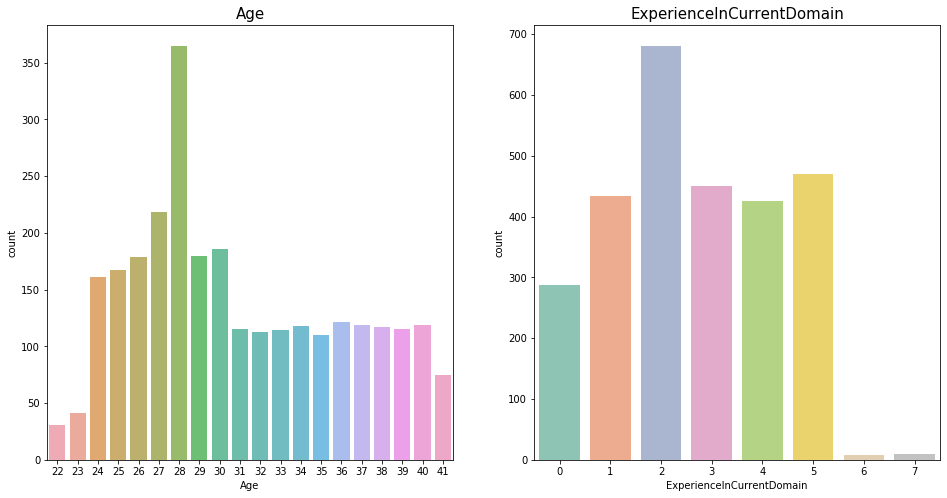

In [13]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title('Age', fontsize=15)
temp = ddf['Age'].value_counts()
sns.countplot(data=ddf, x=ddf['Age'], alpha=0.8)

plt.subplot(1,2,2)
plt.title('ExperienceInCurrentDomain', fontsize=15)
temp = ddf['ExperienceInCurrentDomain'].value_counts()
sns.countplot(data=ddf, x=ddf['ExperienceInCurrentDomain'], palette='Set2', alpha=0.8)

plt.show()

In [14]:
# 우선 데이터 셋을 8:2로 분할합니다.

In [15]:
train, test = train_test_split(ddf, test_size = 0.2, random_state = 2)

In [16]:
# train의 타겟 비율과 test의 타겟 비율을 확인합니다.
# 불균형도가 심하지 않기 때문에 그대로 진행합니다.

In [17]:
print('train_target_rate :', len(train[train['LeaveOrNot']==1])/len(train))
print('test_target_rate :', len(test[test['LeaveOrNot']==1])/len(test))

train_target_rate : 0.3921302578018996
test_target_rate : 0.3996383363471971


In [104]:
train.shape

(2199, 9)

In [106]:
test.shape

(548, 9)

In [18]:
# train test를 조정합니다.

In [19]:
def eda(df):
  # ExperienceInCurrentDomain > Experience로 간략하게 표현, 6년 > 8행, 7년 > 9행으로 적어서 드랍 결정
  df.rename(columns={'ExperienceInCurrentDomain':'Experience'}, inplace=True)
  df = df.drop(df[(df['Experience'] == 6)|(df['Experience'] == 7)].index)

  # Education에서 Bachelors = 1, Masters = 2, PHD = 3으로 변경
  df.loc[df[df['Education'] == 'Bachelors'].index, 'Education'] = 1
  df.loc[df[df['Education'] == 'Masters'].index, 'Education'] = 2
  df.loc[df[df['Education'] == 'PHD'].index, 'Education'] = 3
  df['Education'] = df['Education'].astype(int)
  # # City에서 Bangalore = 1, Pune = 2, New Delhi = 3으로 변경
  # df.loc[df[df['City'] == 'Bangalore'].index, 'City'] = 1
  # df.loc[df[df['City'] == 'Pune'].index, 'City'] = 2
  # df.loc[df[df['City'] == 'New Delhi'].index, 'City'] = 3
  # # EverBenched에서 No = 0, Yes = 1로 변경
  # df.loc[df[df['EverBenched'] == 'No'].index, 'EverBenched'] = 0
  # df.loc[df[df['EverBenched'] == 'Yes'].index, 'EverBenched'] = 1
  # Gender에서 Male = 1, Female = 2로 변경
  # df.loc[df[df['Gender'] == 'Male'].index, 'Gender'] = 1
  # df.loc[df[df['Gender'] == 'Female'].index, 'Gender'] = 2


  # Year - 2010으로 2~8로 표현 변경
  # df['JoiningYear'] = df['JoiningYear'] - 2010

  # Age 그룹화 22-25 = 1, 26-29 = 2, 30-33 = 3, 34-37 = 4, 38-41 = 5
  df.loc[df[(df['Age'] >= 22)&(df['Age'] <= 25)].index, 'Age'] = 1
  df.loc[df[(df['Age'] >= 26)&(df['Age'] <= 29)].index, 'Age'] = 2
  df.loc[df[(df['Age'] >= 30)&(df['Age'] <= 33)].index, 'Age'] = 3
  df.loc[df[(df['Age'] >= 34)&(df['Age'] <= 37)].index, 'Age'] = 4
  df.loc[df[(df['Age'] >= 38)&(df['Age'] <= 41)].index, 'Age'] = 5

  # reset_index
  df = df.reset_index(drop=True)

  return df

In [20]:
train = eda(train)
test = eda(test)

In [21]:
# test는 예측해야 하는 값이므로 시각화 살펴보지 않고, train만 살펴봅니다.

In [22]:
# train 시각화

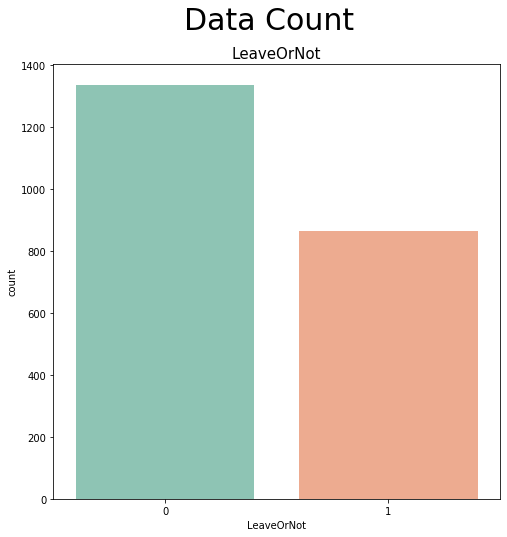

In [23]:
plt.figure(figsize=(8,8))
plt.suptitle("Data Count", fontsize=30)

col = 'LeaveOrNot'
plt.title(col, fontsize=15)
temp = train[col].value_counts()
sns.countplot(data=train, x=col, palette='Set2', alpha=0.8)
plt.show()

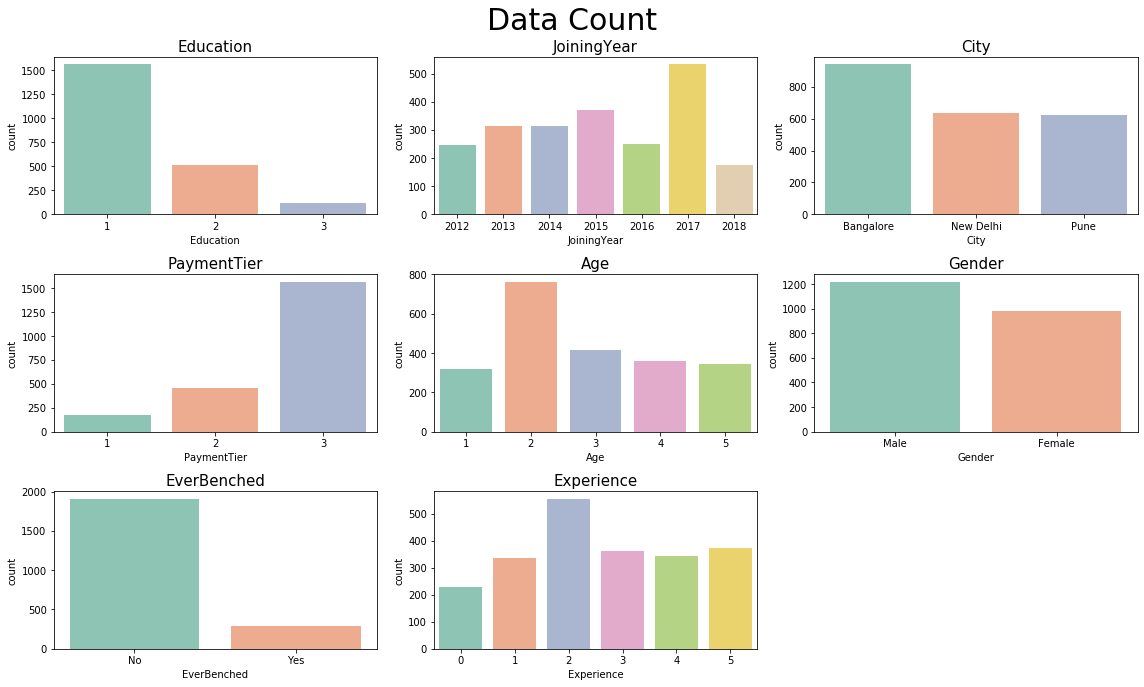

In [24]:
plt.figure(figsize=(16,10))
plt.suptitle("Data Count", fontsize=30)

cols = train.columns
for i in np.arange(0,len(cols)-1):
    plt.subplot(3,3,i+1)
    plt.title(cols[i], fontsize=15)
    temp = train[cols[i]].value_counts()
    sns.countplot(data=train, x=cols[i], palette='Set2', alpha=0.8)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

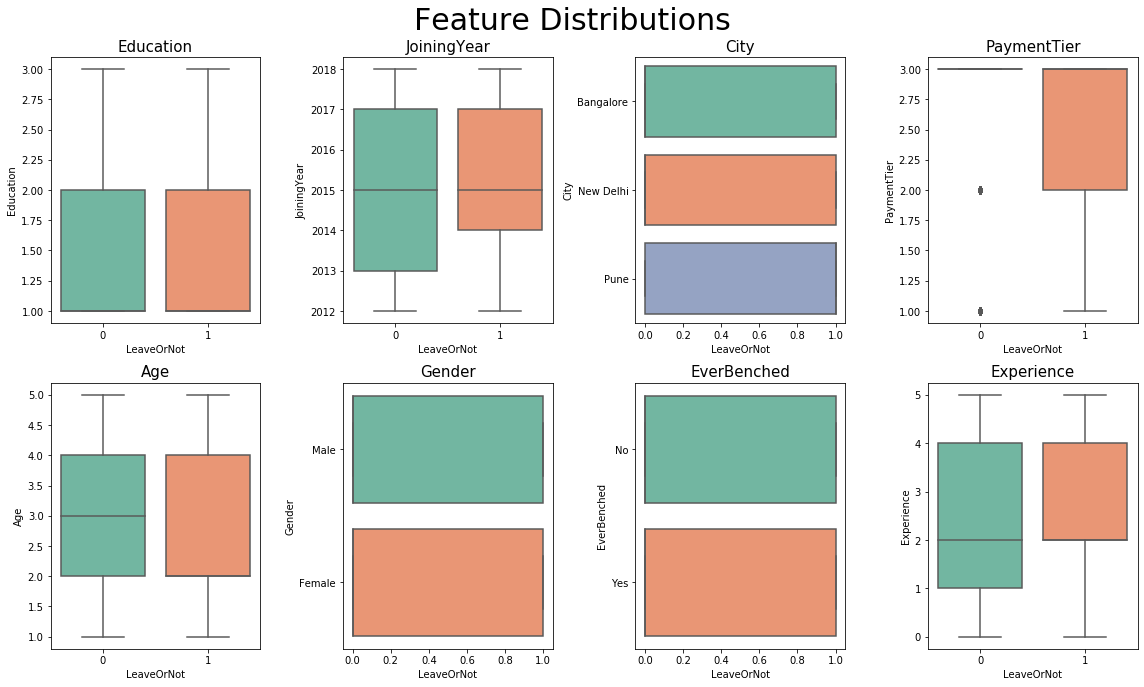

In [107]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

fig.suptitle('Feature Distributions', fontsize= 30)
for ax, col in zip(axes.flat, train.columns[:-1]):
    sns.boxplot(x= 'LeaveOrNot', y= col, ax=ax, data=train, palette='Set2')
    ax.set_title(col, fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [26]:
# 범주형 데이터에서 해당 범주를 벗어나는 이상값은 확인되지 않았으며,
# 수치형 데이터(JoiningYear, Age, Experience)에서 이상값은 확인되지 않는 것을 볼 수 있습니다.

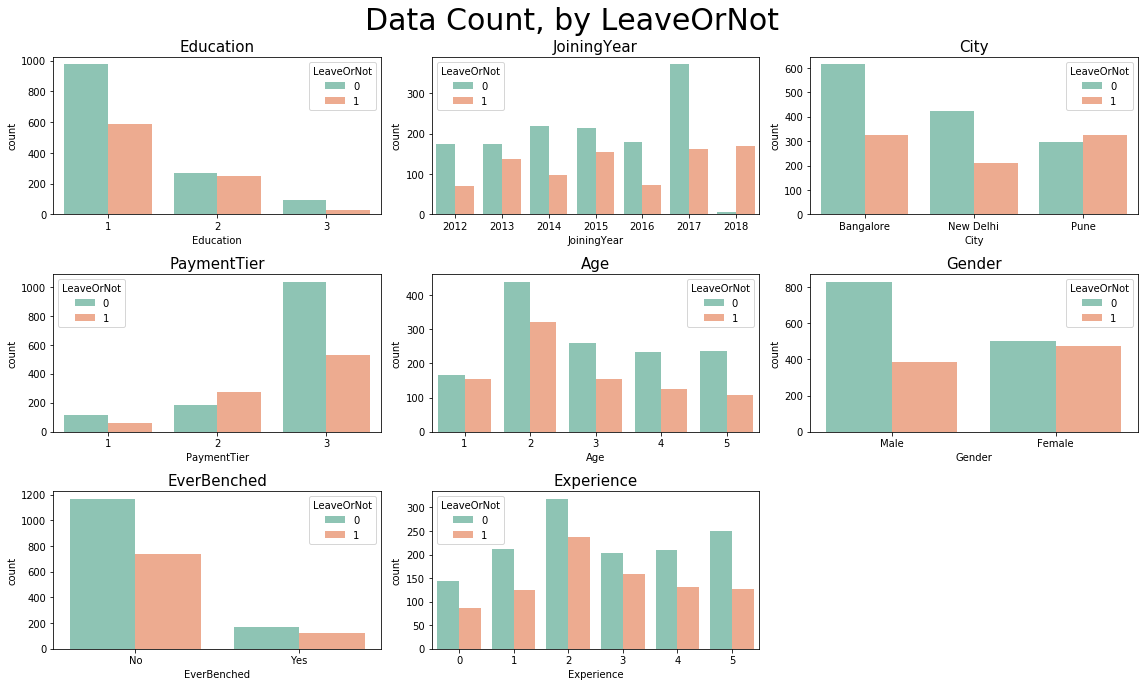

In [27]:
plt.figure(figsize=(16,10))
plt.suptitle("Data Count, by LeaveOrNot", fontsize=30)

cols = train.columns
for i in np.arange(0,len(cols)-1):
    plt.subplot(3,3,i+1)
    plt.title(cols[i], fontsize=15)
    temp = train[cols[i]].value_counts()
    sns.countplot(data=train, x=cols[i], hue='LeaveOrNot', palette='Set2', alpha=0.8)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

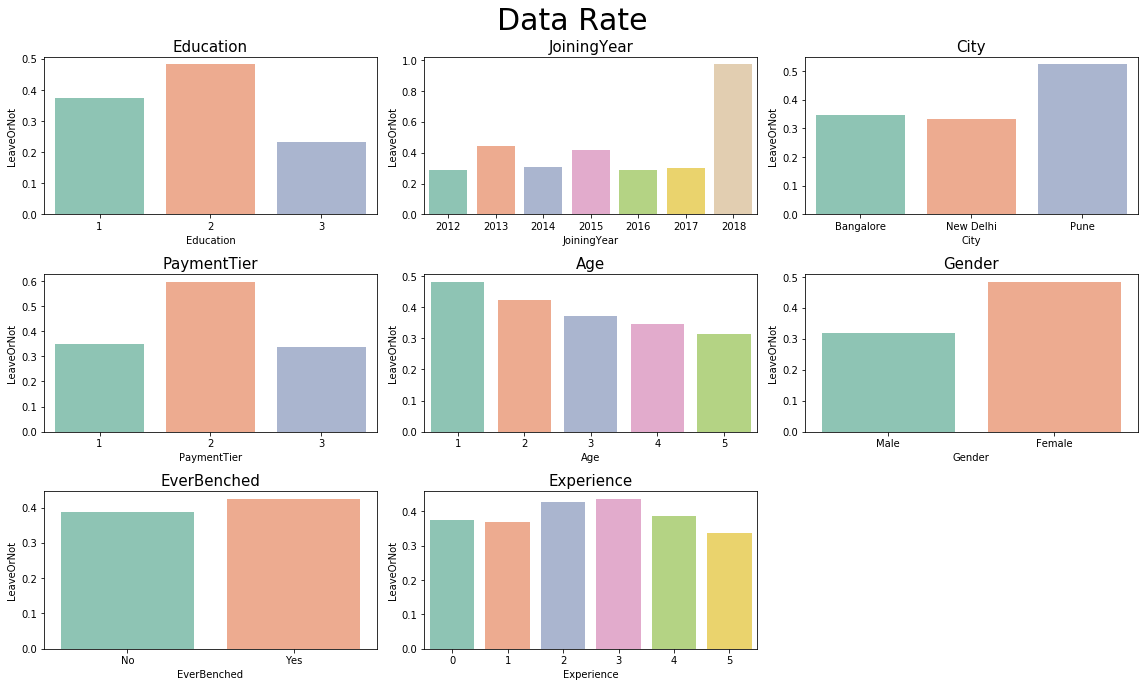

In [88]:
plt.figure(figsize=(16,10))
plt.suptitle("Data Rate", fontsize=30)

cols = train.columns
for i in np.arange(0,len(cols)-1):
    plt.subplot(3,3,i+1)
    plt.title(cols[i], fontsize=15)
    sns.barplot(data=train, x=cols[i], y='LeaveOrNot', ci=None, palette='Set2', alpha=0.8)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 0~1 사이, 1에 가까울수록 Leave 비율이 높다.

In [29]:
# JoininYear을 살펴보면, 최근 입사한 직원일수록 이탈 비율이 높다고 보기 어렵습니다.
# 대신, 가장 최근에 입사(2018년 입사)한 직원들의 이탈 비율이 높다고 볼 수 있습니다.
# >> 최근 회사에 무슨 일이 있었나?

# Age를 살펴보면, 어린 그룹일수록 이탈 비율이 높다고 볼 수 있습니다.

# Experience를 살펴보면, 경력이 낮은 직원의 이탈 비율이 높다고 보기 어렵습니다.
# 오히려 2,3년 경력에서 이탈비율이 높은 것을 확인할 수 있습니다.

In [30]:
# 그 외 특성들을 살펴보면,
# Education에서 2(Masters)의 비율이 높습니다.
# PaymentTier에서 Tier 2의 비율이 높습니다.
# City에서 Pune의 비율이 높습니다.
# Gender에서 Female의 비율이 높습니다.
# EverBenched에서 Yes의 비율이 약간 높습니다.

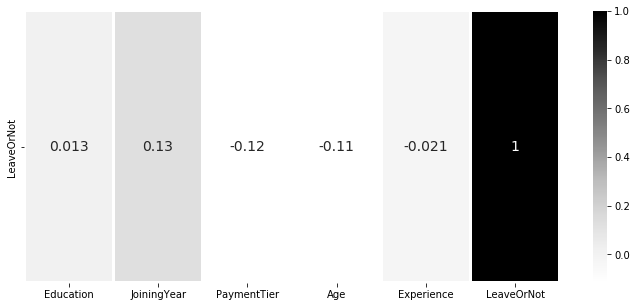

In [110]:
# 수치형 데이터와 타겟 간 상관계수
plt.figure(figsize=(12,5))
sns.heatmap(train.corr()[['LeaveOrNot']].T, annot = True, cmap = "Greys", linewidths = 2, linecolor = "white", cbar = True, annot_kws = {"size":14})
plt.show()

In [32]:
# 독립변수, 종속변수 분리

In [33]:
def x_y_split(df):
  features = df.columns[:-1]
  target = 'LeaveOrNot'

  X = df[features]
  y = df[target]

  return X, y

In [34]:
X_train, y_train = x_y_split(train)
X_test, y_test = x_y_split(test)

In [35]:
# Ordinal 인코딩

In [36]:
ord = OrdinalEncoder()

In [37]:
X_train_ord = ord.fit_transform(X_train)
X_test_ord = ord.fit_transform(X_test)

In [38]:
# 기준모델 > 분류이므로 최빈값으로

In [111]:
base = y_train.mode()[0]
baseline = len(y_train) * [base]
np.round(accuracy_score(y_train, baseline),2)

0.61

In [121]:
xgb = XGBClassifier(random_state = 2)
xgb.fit(X_train_ord, y_train)
scores = cross_val_score(xgb, X_train_ord, y_train, scoring = 'accuracy', cv =5)
print('XGBoost_정확도 :', np.round(scores.mean(),4))
scores = cross_val_score(xgb, X_train_ord, y_train, scoring = 'f1', cv =5)
print('XGBoost_F1 :', np.round(scores.mean(),4))

XGBoost_정확도 : 0.7945
XGBoost_F1 : 0.6893


In [122]:
lgbm = LGBMClassifier(random_state = 2)
lgbm.fit(X_train_ord, y_train)
scores = cross_val_score(lgbm, X_train_ord, y_train, scoring = 'accuracy', cv =5)
print('LightGBM_정확도 :', np.round(scores.mean(),4))
scores = cross_val_score(lgbm, X_train_ord, y_train, scoring = 'f1', cv =5)
print('LightGBM_F1 :', np.round(scores.mean(),4))

LightGBM_정확도 : 0.7853
LightGBM_F1 : 0.6922


In [123]:
ada = AdaBoostClassifier(random_state = 2)
ada.fit(X_train_ord, y_train)
scores = cross_val_score(ada, X_train_ord, y_train, scoring = 'accuracy', cv =5)
print('AdaBoost_정확도 :', np.round(scores.mean(),4))
scores = cross_val_score(ada, X_train_ord, y_train, scoring = 'f1', cv =5)
print('AdaBoost_F1 :', np.round(scores.mean(),4))

AdaBoost_정확도 : 0.7549
AdaBoost_F1 : 0.6256


In [43]:
test_pred = lgbm.predict(X_test_ord)

In [45]:
lgbm = LGBMClassifier(random_state = 2)
params = {
    'num_leaves' : [20,40,60,80,100],
    'min_child_samples' : [5,10,15],
    'max_depth' : [-1,5,10,20],
    'learning_rate' : [0.05,0.1,0.2],
    'reg_alpha' : [0,0.01,0.02,0.03]
}
grid = GridSearchCV(lgbm, params, scoring = 'f1')

grid.fit(X_train_ord, y_train)
print(grid.best_params_)

{'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 10, 'num_leaves': 20, 'reg_alpha': 0}


In [46]:
best_params = grid.best_params_

In [47]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 2)

In [48]:
accuracy_history = []
f1_history = []

for train_index, val_index in kf.split(X_train):
    X_train, X_val = X_train_ord.iloc[train_index], X_train_ord.iloc[val_index]
    Y_train, Y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    y_pred = grid.predict(X_val) # 예측 라벨
    accuracy_history.append(accuracy_score(Y_val, y_pred)) # 정확도 측정 및 기록
    f1_history.append(f1_score(Y_val, y_pred))

In [49]:
accuracy_history

[0.8136363636363636,
 0.8340909090909091,
 0.8409090909090909,
 0.8340909090909091,
 0.8405466970387244]

In [51]:
f1_history

[0.730263157894737,
 0.7402135231316727,
 0.7635135135135135,
 0.765273311897106,
 0.7348484848484849]

In [128]:
print('LightGBM_정확도 :', np.round(np.mean(accuracy_history),4))
print('LightGBM_F1 :', np.round(np.mean(f1_history),4))

LightGBM_정확도 : 0.8327
LightGBM_F1 : 0.7468


In [135]:
lgbm = make_pipeline(
    LGBMClassifier(
        random_state = 2,
        **best_params
    )
)
lgbm.fit(X_train_ord, y_train)

Pipeline(steps=[('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.05, max_depth=10,
                                min_child_samples=10, num_leaves=20,
                                random_state=2, reg_alpha=0))])

In [136]:
train_pred = lgbm.predict(X_train_ord)
print(accuracy_score(y_train, train_pred))
print(f1_score(y_train, train_pred))

0.8326512050932242
0.7472527472527472


In [144]:
test_pred = lgbm.predict(X_test_ord)
print('LightGBM_정확도 :', np.round(accuracy_score(y_test, test_pred),4))
print('LightGBM_F1 :', np.round(f1_score(y_test, test_pred),4))

LightGBM_정확도 : 0.823
LightGBM_F1 : 0.7413


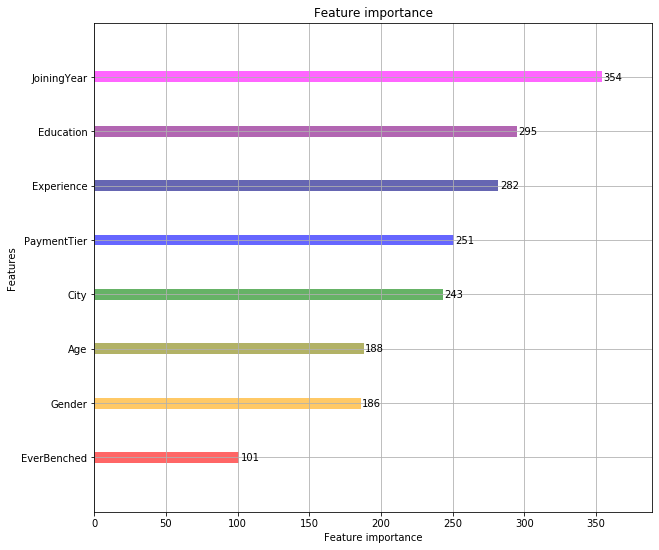

In [139]:
colors = ['red', 'orange', 'olive', 'green', 'blue', 'navy', 'purple', 'magenta']
plot_importance(lgbm.named_steps["lgbmclassifier"], figsize=(10, 9), alpha=0.6, color=colors);

In [66]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    lgbm.named_steps["lgbmclassifier"], 
    scoring="f1",
    n_iter=5,
    random_state=2,
)

permuter.fit(X_test_ord, y_test)

PermutationImportance(estimator=LGBMClassifier(learning_rate=0.05, max_depth=10,
                                               min_child_samples=10,
                                               num_leaves=20, random_state=2,
                                               reg_alpha=0),
                      random_state=2, scoring='f1')

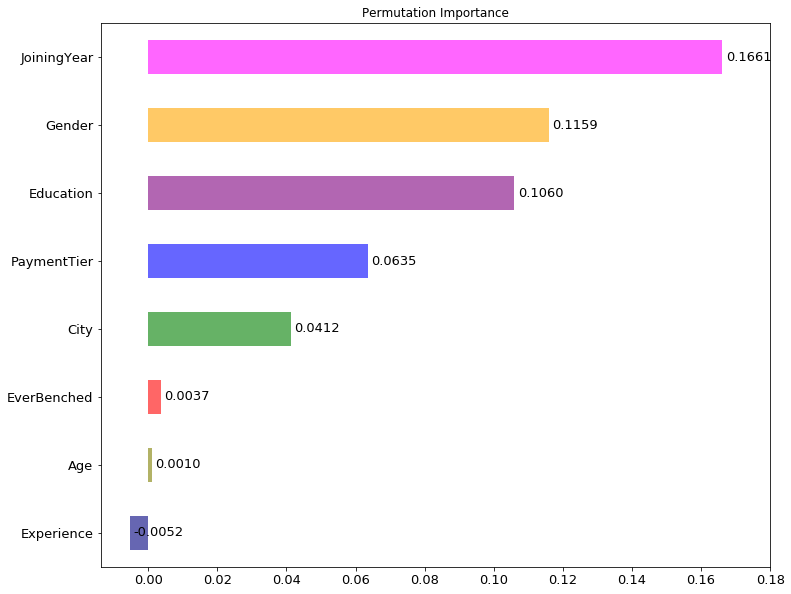

In [142]:
feature_names = X_test.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
plt.figure(figsize=(12,10))
colors = ['navy', 'olive', 'red', 'green', 'blue', 'purple', 'orange', 'magenta']
pi.plot.barh(alpha=0.6, color=colors)
cnt=0
for i in pi.values:
    plt.text(x=i+0.001, y=cnt, s=str('{:.4f}'.format(i)),
            color='black', size=13, va='center')
    cnt+=1
plt.title("Permutation Importance")
plt.xticks(np.arange(0, 0.181, 0.02), fontsize=13)
plt.yticks(fontsize=13)
plt.show()

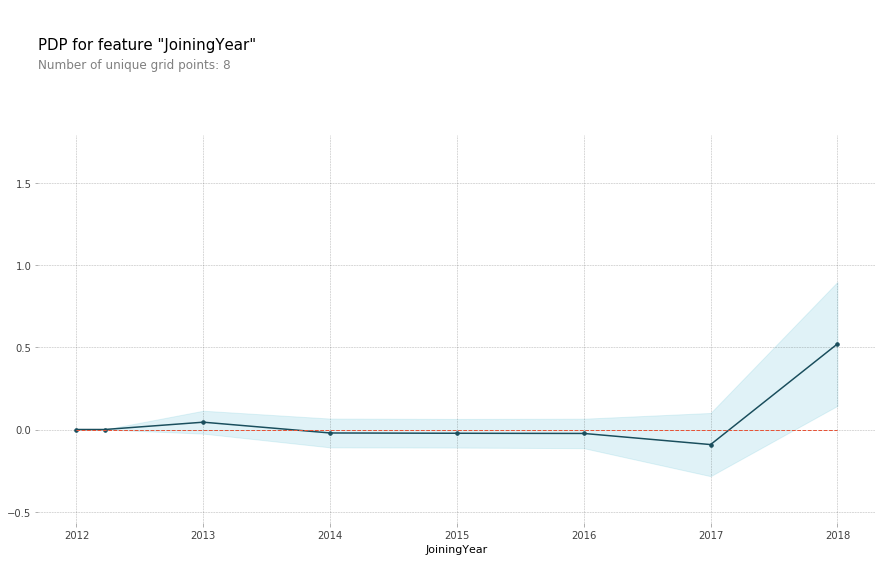

In [61]:
target_feature = "JoiningYear"

isolated = pdp_isolate(
    model=lgbm.named_steps["lgbmclassifier"],
    dataset=X_train_ord,
    model_features=X_train_ord.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)
plt.show()

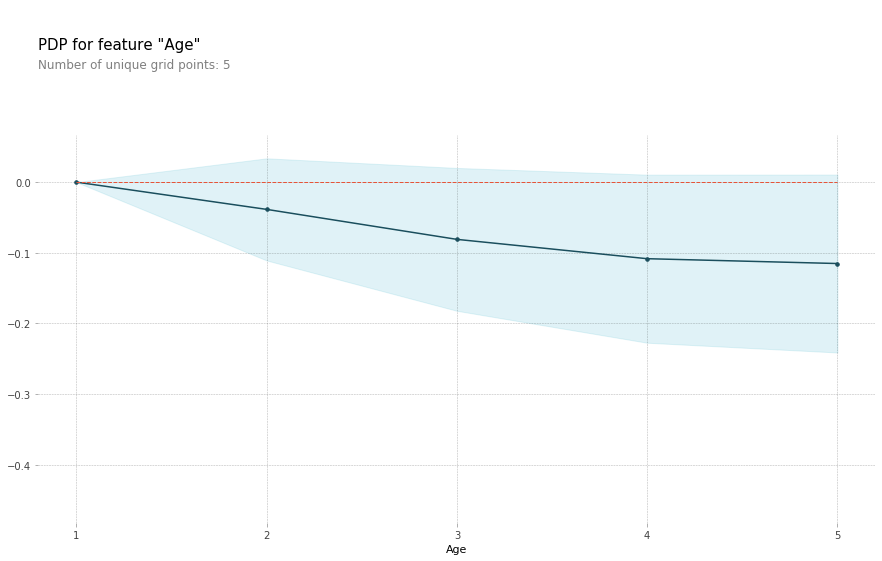

In [64]:
target_feature = "Age"

isolated = pdp_isolate(
    model=lgbm.named_steps["lgbmclassifier"],
    dataset=X_train_ord,
    model_features=X_train_ord.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)
plt.xticks([1,2,3,4,5])
plt.show()

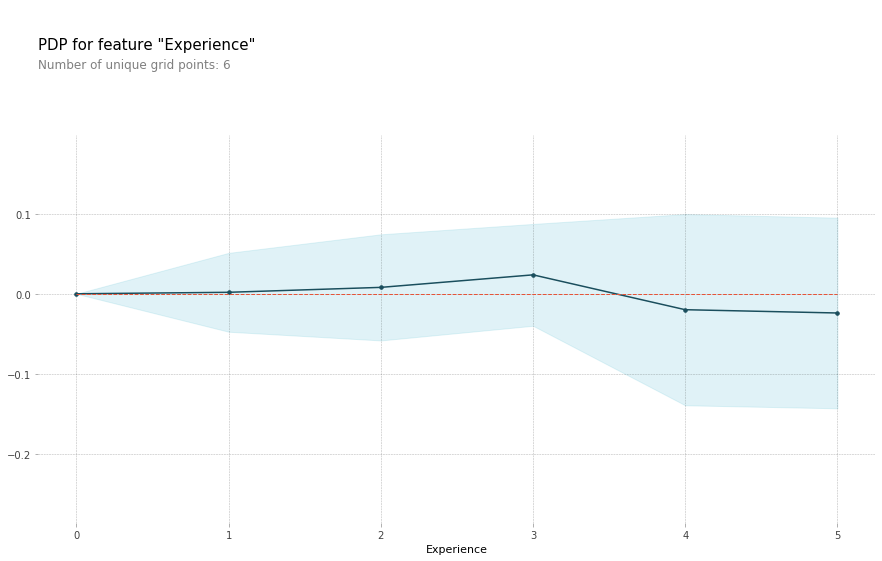

In [63]:
target_feature = "Experience"

isolated = pdp_isolate(
    model=lgbm.named_steps["lgbmclassifier"],
    dataset=X_train_ord,
    model_features=X_train_ord.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)
plt.show()